In [8]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import math
import seaborn as sns; sns.set()

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from sklearn.metrics import roc_curve, precision_score, recall_score, classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier

import warnings
warnings.filterwarnings("ignore")

In [45]:
train = pd.read_csv("./gss.csv")

In [ ]:
#### LOAD OTHER DATASETS ####
data_2014 = pd.read_csv("./gss-2014.csv")
data_2016 = pd.read_csv("./gss-2016.csv")

In [ ]:
binary_train = train.copy()
binary_train = binary_train[['COHORT','AGEKDBRN','DEGREE','PADEG','MADEG','SEX','RACE','RES16','MAWRKGRW','INCOM16','BORN','PARBORN','SIBS','FAMILY16','RELIG16','FUND16','RESPNUM','FAMGEN','OTHLANG']]

data_2014 = data_2014[['COHORT','AGEKDBRN','DEGREE','PADEG','MADEG','SEX','RACE','RES16','MAWRKGRW','INCOM16','BORN','PARBORN','SIBS','FAMILY16','RELIG16','FUND16','RESPNUM','FAMGEN','OTHLANG','INTAGE']]
data_2016 = data_2016[['COHORT','AGEKDBRN','DEGREE','PADEG','MADEG','SEX','RACE','RES16','MAWRKGRW','INCOM16','BORN','PARBORN','SIBS','FAMILY16','RELIG16','FUND16','RESPNUM','FAMGEN','OTHLANG','INTAGE']]

In [ ]:
#### COMBINE DATASETS ####
binary_train = binary_train.append(data_2014)
binary_train = binary_train.append(data_2016)

In [46]:
grad = (binary_train.DEGREE > 2) & (binary_train.DEGREE < 5)
not_grad = (binary_train.DEGREE <= 2) | (binary_train.DEGREE > 4)
binary_train.loc[grad, 'DEGREE'] = 1
binary_train.loc[not_grad, 'DEGREE'] = 0

In [11]:
print("How many graduated: " + str(binary_train.DEGREE.sum()))
ratio = binary_train.DEGREE.sum() * 100 / binary_train.DEGREE.count()
print("Ratio: " + str(round(ratio, 2)) + "%")

How many graduated: 1314
Ratio: 31.21%


In [12]:
binary_train_y = binary_train.DEGREE
binary_train_x = binary_train.drop(['DEGREE'], axis=1)

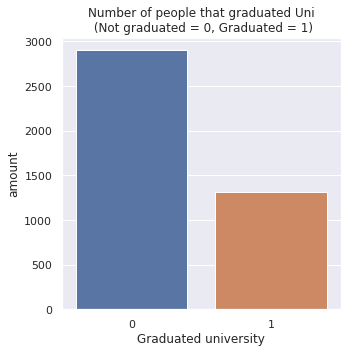

In [6]:
count = binary_train_y.value_counts()
df = pd.DataFrame({'Graduated university': count.index, 'amount': count.values})
plt.figure(figsize = (5, 5))
plt.title('Number of people that graduated Uni\n (Not graduated = 0, Graduated = 1)')
sns.set_color_codes("bright")
sns.barplot(x = 'Graduated university', y="amount", data=df)
locs, labels = plt.xticks()
plt.show()

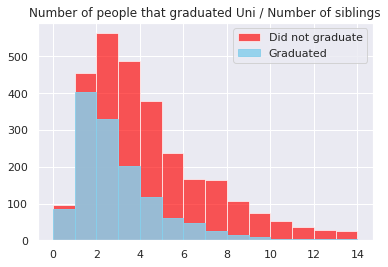

In [7]:
# Testing the number of people that graduated uni 

# To find different columns' histograms, just change 'SIBS' to the column you'd like, below
binary_train_sibsND = binary_train.loc[not_grad, 'SIBS']
binary_train_sibsD = binary_train.loc[grad, 'SIBS']
bins = np.arange(0, 15)

plt.title('Number of people that graduated Uni / Number of siblings')
plt.hist(binary_train_sibsND, bins, alpha=0.65, label='Did not graduate', color = "#FF0000")
plt.hist(binary_train_sibsD, bins, alpha=0.85, label='Graduated', color = "skyblue", ec="skyblue")
plt.legend(loc='upper right')
plt.show()

In [21]:
print("Siblings statistics for non-graduate v. graduated")
stats_df = pd.DataFrame()
stats_df["Did not graduate"] = binary_train_sibsND.describe().round(2)
stats_df["Graduated"] = binary_train_sibsD.describe().round(2)
stats_df.loc[-1] = [binary_train_sibsND.median(), binary_train_sibsD.median()]
stats_df.rename({-1 : 'median'}, inplace=True)
stats_df.head(9)

Siblings statistics for non-graduate v. graduated


Did not graduate  Graduated
count            2896.00    1314.00
mean                3.98       2.53
std                 3.25       2.13
min                 0.00       0.00
25%                 2.00       1.00
50%                 3.00       2.00
75%                 5.00       3.00
max                58.00      20.00
median              3.00       2.00

In [47]:
##### CODING INFO ######

## COHORT is the year the respondent was born
## AGEKDBRN: 1 = respondent had a child whilst a teenager, 0 if not
## DEGREE: 1 = respondent graduated college, 0 if not
## PADEG: 1 = respondent has a father that graduated college
## MADEG: 1 = respondent has a mother that graduated college
## SEX: 1 = Male, 2 = Female
## RACE: 1 = White, 2 = Black, 3 = Other
## RES16: 1 = Country, no farm, 2 = Farm, 3 = Town lt 50000, 4 = 50000 to 250000, 5 = Big-city suburb, 6 = City gt 250000
## MAWRKGRW: 1 = respondent had a mother who was in employment when r was 16, 0 if not
## INCOM16: 1 = Far below average, 2 = Below average, 3 = Average, 4 = Above average, 5 = Far above average
## BORN: 1 = R was born in this country, 0 if not
## PARBORN: 1 = one US born parent, 2 = 2 US born parents, 0 = no US born parents
## SIBS: number of siblings R has
## FAMILY16: 2 = living with both parents, 1 = living with 1 parent, 0 = living with neither parent
## RELIG16: 0 = None, 1 = Christianity, 2 = Judaism, 3 = Hinduism, 4 = Buddhism, 5 = Islam, 6 = Native American Religion, 7 = Other
## FUND16: 1 = Fundamentalist, 2 = Moderate, 3 = Liberal 
## RESPNUM: Number of people in R's family
## FAMGEN: Number of generations in R's household 
## OTHLANG: 1 if bilingual, 0 if not

## code AGEKDBRN as "Teenage parenthood?" variable - 1 for teenage parent, 0 for not teenage parent

teenage_parent = (binary_train.AGEKDBRN != 0) & (binary_train.AGEKDBRN <20)
not_teenage_parent = (binary_train.AGEKDBRN ==0) | (binary_train.AGEKDBRN >19)
binary_train.loc[teenage_parent, 'AGEKDBRN'] = 1
binary_train.loc[not_teenage_parent, 'AGEKDBRN'] = 0

print("How many teenage parents: " + str(binary_train.AGEKDBRN.sum()))
ratio = binary_train.AGEKDBRN.sum() * 100 / binary_train.AGEKDBRN.count()
print("Percentage: " + str(round(ratio, 2)) + "%\n")

## code PADEG data - 1 if respondent has father who graduated college

father_grad = (binary_train.PADEG == 3) | (binary_train.PADEG == 4)
father_not_grad = (binary_train.PADEG <= 2) | (binary_train.PADEG == 7)
binary_train.loc[father_grad, 'PADEG'] = 1
binary_train.loc[father_not_grad, 'PADEG'] = 0

print("How many respondents had fathers who graduated: " + str(binary_train.PADEG.sum()))
ratio = binary_train.PADEG.sum() * 100 / binary_train.PADEG.count()
print("Percentage: " + str(round(ratio, 2)) + "%\n")

## code MADEG data - 1 if respondent has mother who graduated college, 0 if not

mother_grad = (binary_train.MADEG == 3) | (binary_train.MADEG == 4)
mother_not_grad = (binary_train.MADEG <= 2) | (binary_train.MADEG == 7)
binary_train.loc[mother_grad, 'MADEG'] = 1
binary_train.loc[mother_not_grad, 'MADEG'] = 0

print("How many respondents had mothers who graduated: " + str(binary_train.MADEG.sum()))
ratio = binary_train.MADEG.sum() * 100 / binary_train.MADEG.count()
print("Percentage: " + str(round(ratio, 2)) + "%\n")

## code MAWRKGRW data - 1 if respondent had a mother who was in employment when r was 16, 0 if not

mother_in_employment = (binary_train.MAWRKGRW == 1)
mother_not_in_employment = (binary_train.MAWRKGRW == 0) | (binary_train.MAWRKGRW == 2)
binary_train.loc[mother_in_employment, 'MAWRKGRW'] = 1
binary_train.loc[mother_not_in_employment, 'MAWRKGRW'] = 0

print("How many respondents had mothers who were in employment: " + str(binary_train.MAWRKGRW.sum()))
ratio = binary_train.MAWRKGRW.sum() * 100 / binary_train.MAWRKGRW.count()
print("Percentage: " + str(round(ratio, 2)) + "%\n")

## code BORN - 1 if R was born in the US, 0 if not

born_in_US = (binary_train.BORN == 1)
not_born_in_US = (binary_train.BORN == 2)
binary_train.loc[born_in_US, 'BORN'] = 1
binary_train.loc[not_born_in_US, 'BORN'] = 0

print("How many respondents where born in the US: " + str(binary_train.BORN.sum()))
ratio = binary_train.BORN.sum() * 100 / binary_train.BORN.count()
print("Percentage: " + str(round(ratio, 2)) + "%\n")

## code PARBORN - 1 = one US born parent, 2 = 2 US born parents, 0 = no US born parents

two_US_born_parents = (binary_train.PARBORN == 0)
one_US_born_parent = (binary_train.PARBORN == 1) | (binary_train.PARBORN == 2) | (binary_train.PARBORN == 3) | (binary_train.PARBORN == 5)
no_US_born_parents = (binary_train.PARBORN == 4) | (binary_train.PARBORN == 6) | (binary_train.PARBORN == 8)

binary_train.loc[two_US_born_parents, 'PARBORN'] = 2
binary_train.loc[one_US_born_parent, 'PARBORN'] = 1
binary_train.loc[no_US_born_parents, 'PARBORN'] = 0

## code FAMILY16 - 2 = living with both parents, 1 = living with 1 parent, 0 = living with neither parent

living_with_2_parents = (binary_train.FAMILY16 == 1)
living_with_1_parent = (binary_train.FAMILY16 >1 ) & (binary_train.FAMILY16 < 6)
living_with_neither_parent = (binary_train.FAMILY16 == 0) | (binary_train.FAMILY16 == 6) | (binary_train.FAMILY16 == 7) | (binary_train.FAMILY16 == 8)

binary_train.loc[living_with_2_parents, 'FAMILY16'] = 2
binary_train.loc[living_with_1_parent, 'FAMILY16'] = 1
binary_train.loc[living_with_neither_parent, 'FAMILY16'] = 0

## code RELIG16: 0 = None, 1 = Christianity, 2 = Judaism, 3 = Hinduism, 4 = Buddhism, 5 = Islam, 6 = Native American Religion, 7 = Other

christian = (binary_train.RELIG16 == 1) | (binary_train.RELIG16 == 2) | (binary_train.RELIG16 == 10) | (binary_train.RELIG16 == 11)
jewish = (binary_train.RELIG16 == 3)
no_religion = (binary_train.RELIG16 == 0) | (binary_train.RELIG16 == 4)
hinduism = (binary_train.RELIG16 == 7)
buddhism = (binary_train.RELIG16 == 6)
islam = (binary_train.RELIG16 == 9)
native_american = (binary_train.RELIG16 == 12)
other = (binary_train.RELIG16 == 5)

binary_train.loc[christian, 'RELIG16'] = 2
binary_train.loc[jewish, 'RELIG16'] = 1
binary_train.loc[hinduism, 'RELIG16'] = 0
binary_train.loc[buddhism, 'RELIG16'] = 4
binary_train.loc[islam, 'RELIG16'] = 5
binary_train.loc[native_american, 'RELIG16'] = 6
binary_train.loc[other, 'RELIG16'] = 7

## code FAMGEN - number of generations in R's house

one_gen = (binary_train.FAMGEN == 1)
two_gens = (binary_train.FAMGEN == 2) | (binary_train.FAMGEN == 3) | (binary_train.FAMGEN == 4)
three_gens = (binary_train.FAMGEN > 4)

binary_train.loc[one_gen, 'FAMGEN'] = 1
binary_train.loc[two_gens, 'FAMGEN'] = 2
binary_train.loc[three_gens, 'FAMGEN'] = 3

## code OTHLANG data - 1 is bilingual, 0 is monolingual

bilingual = (binary_train.OTHLANG ==1)
monolingual = (binary_train.OTHLANG ==0) | (binary_train.OTHLANG ==2)
binary_train.loc[bilingual, 'OTHLANG'] = 1
binary_train.loc[monolingual, 'OTHLANG'] = 0

print("How many bilingual: " + str(binary_train.OTHLANG.sum()))
ratio = binary_train.OTHLANG.sum() * 100 / binary_train.OTHLANG.count()
print("Percentage: " + str(round(ratio, 2)) + "%\n")


How many teenage parents: 669
Percentage: 15.89%

How many respondents had fathers who graduated: 694
Percentage: 16.48%

How many respondents had mothers who graduated: 626
Percentage: 14.87%

How many respondents had mothers who were in employment: 2994
Percentage: 71.12%

How many respondents where born in the US: 3788
Percentage: 89.98%

Counter({2: 2898, 1: 1082, 0: 230})
How many bilingual: 465
Percentage: 11.05%

